# CIFAR 10 Example
`INTRO Placeholder`

### What is CIFAR 10?
Taken straight from the [website](https://www.cs.toronto.edu/~kriz/cifar.html):
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

### What is the goal?
As the explanation says - use the test set and see what scores I can get using a ConvNet (via PyTorch).

### Project Structure:
(to be updated)
1. Loading the data
...

### References
* [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky

## 1.Loading the data.
*Comment: I intend to use PyTorch for this example, and while PyTorch does include the CIFAR-10 dataset, I prefer to load it manually.*  
Refering to the dataset's [website](https://www.cs.toronto.edu/~kriz/cifar.html) it is quite easy to figure out the structure:
The dataset is separated into 5 batches with an additional test set. The author even includes a tiny script to load the data.

In [2]:
# importing libraries to help with the loading of the dataset
import pickle
import os

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict1 = pickle.load(fo, encoding='bytes')
    return dict1

def load_data(dataset_path):
    # get all the items in the folder
    batch_list = os.listdir(dataset_path)
    # since we dont need the html and the metal files - skip them
    batch_list = [item for item in batch_list if item != 'readme.html' if item != 'batches.meta']
    # create a master dict to store all of the data
    data_dict = {}
    # print the items, so we may have a reference further down
    print(batch_list)
    # load all of the items
    for item in batch_list:
        data_dict[item] = unpickle(dataset_path + item)
    
    return data_dict

In [4]:
data = load_data('./datasets/cifar-10-python/cifar-10-batches-py/')

['data_batch_2', 'data_batch_3', 'data_batch_1', 'data_batch_5', 'test_batch', 'data_batch_4']


## 2. Loading the Libraries

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Set the device to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First I will try to mimic the tutorial from Torch's website then implement it my way.

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Showing a sample images

  car plane horse  deer


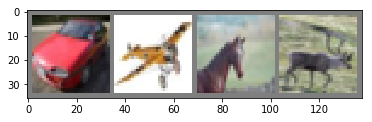

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Defining a Convolutional Neural Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
net = Net()

#### Defining a Loss function and optimizer

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Training the Network

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.308
[1,  4000] loss: 1.761
[1,  6000] loss: 1.610
[1,  8000] loss: 1.524
[1, 10000] loss: 1.482
[1, 12000] loss: 1.419
[2,  2000] loss: 1.315
[2,  4000] loss: 1.312
[2,  6000] loss: 1.290
[2,  8000] loss: 1.245
[2, 10000] loss: 1.250
[2, 12000] loss: 1.242
Finished Training


GroundTruth:  cat ship ship plane


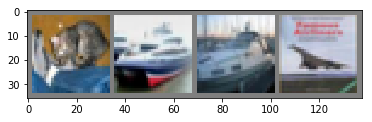

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%s' %classes[labels[j]] for j in range(4)))

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %
